<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/TensorFlowSteve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta


In [4]:
auth.authenticate_user()

In [5]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [6]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
- [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [189]:
# z = zipfile.ZipFile('train-data_all-train-events.zip', 'r')

x = {}
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if (prevLoco != currentLoco and "trainActualPositionList" in lastTrainReporting and "trainEstimatedPositionList" in lastTrainReporting and len(lastTrainReporting['trainEstimatedPositionList']) > 0):
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    for position in trainActualPositionList:
                        positions = pd.json_normalize(position)
                        trains[i] = pd.json_normalize(lastTrainReporting)
#                             x[i] = pd.concat([train.ptcLeadLocomotiveId,trains[i]["trainId.trainSymbol"], trains[i]["trainId.trainDate"], positions], axis=1)
                        x[i] = positions
#                             trains[i] = train 
                        i = i + 1
                        prevLoco = currentLoco
                            

In [190]:
df = pd.concat(x.values())
dfTrains = pd.concat(trains.values())

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   positionTime                                          1696 non-null   object 
 1   speedMPH                                              1696 non-null   int64  
 2   milepostLocation.subdivisionId                        1696 non-null   int64  
 3   milepostLocation.trackName                            1696 non-null   object 
 4   milepostLocation.milepost.milepostNumber              1696 non-null   float64
 5   nextSignalState.milepostLocation.milepostNumber       1106 non-null   float64
 6   nextSignalState.signalState                           1106 non-null   float64
 7   precedingSignalState.milepostLocation.milepostNumber  1166 non-null   float64
 8   precedingSignalState.previousSignalState              996 non

In [192]:
dfTrains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 0
Data columns (total 44 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        1696 non-null   object 
 1   maximumTrainSpeed                                                          1696 non-null   int64  
 2   loadedCarCount                                                             1696 non-null   int64  
 3   emptyCarCount                                                              1696 non-null   int64  
 4   trainLength                                                                1696 non-null   int64  
 5   trailingTonnage                                                            1696 non-null   int64  
 6   positionHistoryList                                        

# Step 1: Compute the accuracy of the Existing Physics BEoP model

In [243]:
dfTrains = dfTrains.drop_duplicates(subset=['ptcLeadLocomotiveId', 'trainId.trainSymbol', 'trainId.trainDate'], keep='first')
print(dfTrains.shape)


(38, 44)


In [250]:
def formatTrain(dfTrain):
  actuals = pd.json_normalize(dfTrain['trainActualPositionList'])
  cols = list(actuals.columns)
  dfx = (actuals[cols[0:2] + cols[3:5]])
  dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
  est = pd.json_normalize(dfTrain['trainEstimatedPositionList'])  
  beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
  joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
  dn = joined.dropna()
  delta = abs(dn["speedMPH"] - dn["forecastSpeedMPH"]);
  dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
  dn["delta"] = delta
  dn = dn.drop(columns=['milepostLocation.subdivisionId'])
  return dn

In [251]:
trains = []
for index, train in dfTrains.iterrows():
  trainId = train['trainId.trainSymbol']+" of "+train['trainId.trainDate']
  trains.append([trainId, formatTrain(train)])
trains[11]

['MCHCB of 2022-04-22',
        positionTime_beop  forecastSpeedMPH forecastTrackName  \
 0   2022-04-23T11:21:01Z                 8              MT 2   
 1   2022-04-23T11:23:01Z                17              MT 2   
 2   2022-04-23T11:25:01Z                24              MT 2   
 3   2022-04-23T11:27:01Z                29              MT 2   
 4   2022-04-23T11:29:01Z                32              MT 2   
 5   2022-04-23T11:31:01Z                36              MT 2   
 6   2022-04-23T11:33:01Z                39              MT 2   
 7   2022-04-23T11:35:01Z                41              MT 2   
 8   2022-04-23T11:37:01Z                43              MT 2   
 9   2022-04-23T11:39:01Z                46              MT 2   
 10  2022-04-23T11:41:01Z                48              MT 2   
 11  2022-04-23T11:43:01Z                49              MT 2   
 12  2022-04-23T11:45:01Z                50              MT 2   
 13  2022-04-23T11:47:01Z                50              MT 2   
 

convert all data to positvive values

In [252]:
def plotTrain(trainData):
  ax = plt.gca()
  trainDF = trainData[1]
  trainDF = trainDF.reset_index();
  trainDF.plot(x = 'index', y="speedMPH", use_index=True, kind="scatter", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'index', y="forecastSpeedMPH", use_index=True, kind="scatter", color="red", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'index', y="delta", use_index=True, kind="line", color="green", ax=ax, figsize=[24,10])
  # plt.gcf().autofmt_xdate()
  plt.title(trainData[0])
  plt.show()

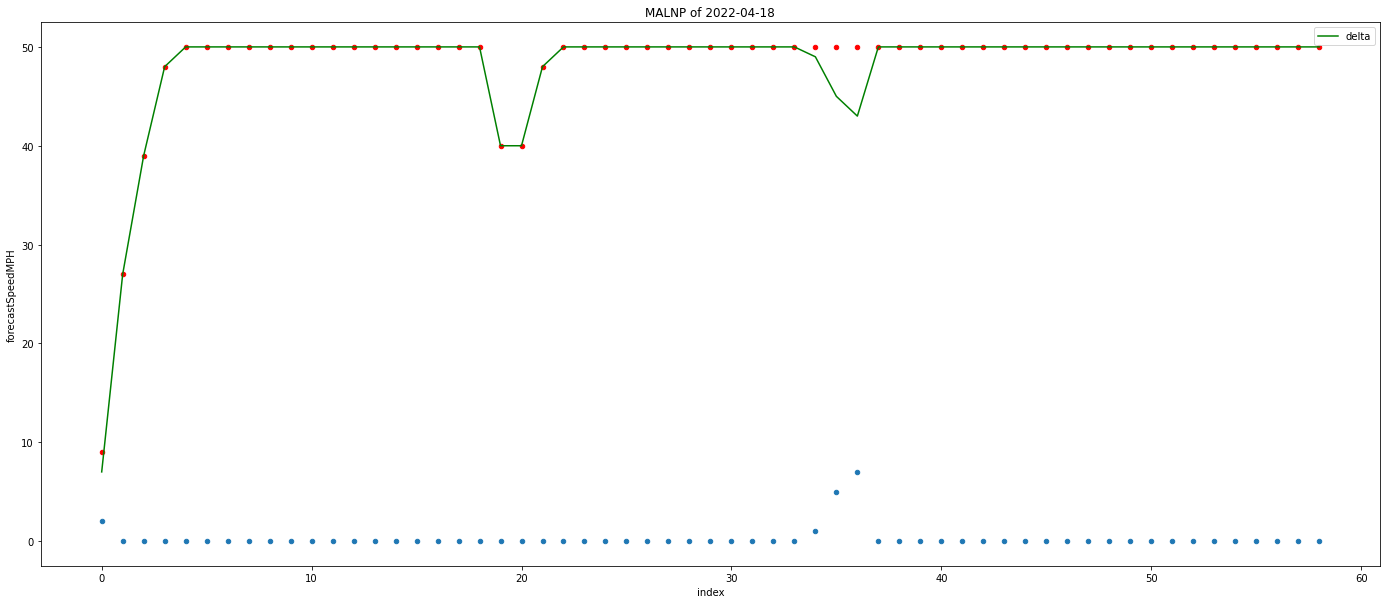

In [261]:
plotTrain(trains[6])

,ptcLeadLocomotiveId,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,aotuTrainData.categoryCode
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12
0,UP2528,,MGBNP,2022-04-15,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   positionTime                                          2621 non-null   object 
 1   speedMPH                                              2621 non-null   int64  
 2   milepostLocation.subdivisionId                        2621 non-null   int64  
 3   milepostLocation.trackName                            2621 non-null   object 
 4   milepostLocation.milepost.milepostNumber              2621 non-null   float64
 5   precedingSignalState.milepostLocation.milepostNumber  2621 non-null   float64
 6   precedingSignalState.previousSignalState              2236 non-null   float64
 7   precedingSignalState.currentStateTime                 2236 non-null   object 
 8   precedingSignalState.signalState                      2621 no

In [ ]:
# df = df.drop(columns=['milepost'])
df['milepost'] = df.apply(lambda row: math.trunc(row['milepostLocation.milepost.milepostNumber']), axis=1)
df['millis'] = df.apply(lambda row: ((datetime.strptime(row['positionTime'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
df.head(10)

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber,precedingSignalState.milepostLocation.milepostNumber,precedingSignalState.previousSignalState,precedingSignalState.currentStateTime,precedingSignalState.signalState,nextSignalState.milepostLocation.milepostNumber,nextSignalState.signalState,nextSignalState.previousSignalState,nextSignalState.currentStateTime,milepost,millis
0,2022-04-17T03:22:02Z,11,106,MT 1,202.74315,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165722000
0,2022-04-17T03:24:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165842000
0,2022-04-17T03:26:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165962000
0,2022-04-17T03:28:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166082000
0,2022-04-17T03:30:02Z,0,106,MT 1,202.89800,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166202000
0,2022-04-17T03:32:02Z,0,106,MT 1,202.89800,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166322000
0,2022-04-17T03:34:02Z,4,106,MT 1,203.04080,202.73,4.0,2022-04-17T03:21:52Z,1,204.19,4.0,NaN,NaN,203,1650166442000
0,2022-04-17T03:36:02Z,11,106,MT 1,203.35143,202.73,4.0,2022-04-17T03:21:52Z,1,204.19,4.0,NaN,NaN,203,1650166562000
0,2022-04-17T03:38:02Z,18,106,MT 1,203.90045,202.73,4.0,2022-04-17T03:21:52Z,1,204.19,4.0,NaN,NaN,203,1650166682000
0,2022-04-17T03:40:02Z,26,106,MT 1,204.44950,204.19,4.0,2022-04-17T03:39:35Z,2,205.94,4.0,NaN,NaN,204,1650166802000


In [ ]:
dfAll = pd.concat([df3, df],axis=1)

In [ ]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 0 to 0
Data columns (total 20 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   ptcLeadLocomotiveId                                   2621 non-null   object 
 1   trainId.trainSection                                  2621 non-null   object 
 2   trainId.trainSymbol                                   2621 non-null   object 
 3   trainId.trainDate                                     2621 non-null   object 
 4   aotuTrainData.categoryCode                            2621 non-null   int64  
 5   positionTime                                          2621 non-null   object 
 6   speedMPH                                              2621 non-null   int64  
 7   milepostLocation.subdivisionId                        2621 non-null   int64  
 8   milepostLocation.trackName                            2621 no

In [ ]:
dfAll.head()

,ptcLeadLocomotiveId,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,aotuTrainData.categoryCode,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber,precedingSignalState.milepostLocation.milepostNumber,precedingSignalState.previousSignalState,precedingSignalState.currentStateTime,precedingSignalState.signalState,nextSignalState.milepostLocation.milepostNumber,nextSignalState.signalState,nextSignalState.previousSignalState,nextSignalState.currentStateTime,milepost,millis
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:22:02Z,11,106,MT 1,202.74315,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165722000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:24:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165842000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:26:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650165962000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:28:02Z,0,106,MT 1,202.89820,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166082000
0,UP2528,,MGBNP,2022-04-15,12,2022-04-17T03:30:02Z,0,106,MT 1,202.89800,202.73,4.0,2022-04-17T03:21:52Z,1,NaN,NaN,NaN,NaN,202,1650166202000


In [ ]:
dfAll.tail()

,ptcLeadLocomotiveId,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,aotuTrainData.categoryCode,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber,precedingSignalState.milepostLocation.milepostNumber,precedingSignalState.previousSignalState,precedingSignalState.currentStateTime,precedingSignalState.signalState,nextSignalState.milepostLocation.milepostNumber,nextSignalState.signalState,nextSignalState.previousSignalState,nextSignalState.currentStateTime,milepost,millis
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:36:34Z,34,106,MT 1,247.75676,245.93,4.0,2022-04-11T00:33:47Z,2,247.98,4.0,9.0,2022-04-11T00:24:15Z,247,1649637394000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:38:34Z,29,106,MT 1,248.75430,247.98,4.0,2022-04-11T00:36:59Z,1,249.62,4.0,NaN,NaN,248,1649637514000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:40:34Z,27,106,MT 1,249.62857,249.62,4.0,2022-04-11T00:40:43Z,2,251.06,4.0,NaN,NaN,249,1649637634000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:42:34Z,26,106,MT 1,250.50282,249.62,4.0,2022-04-11T00:40:43Z,2,251.06,4.0,NaN,NaN,250,1649637754000
0,UP6459,,MPRNP,2022-04-09,12,2022-04-11T00:44:34Z,25,106,MT 1,251.32497,251.06,4.0,2022-04-11T00:44:07Z,2,252.46,4.0,4.0,2022-04-11T00:32:59Z,251,1649637874000


In [ ]:

val = dfAll.iloc[0,5]
millis = ((datetime.strptime(val, "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1)
millis

1650165722000

# dfAll has actual readings by loco/train, 60 per, on

In [ ]:
# Define Utility Functions to build additional data rows

# Create a dataframe row holding a record of position on the train.
def createPositionHistoryFrame(positionHistory) -> dict:
    # The time that the train was at the specific milepost
    # Record the position time as seconds from epoch to use in regression model
    positionTime = positionHistory.get('positionTime')
    # How fast the train is traveling
    speedMPH = positionHistory.get('speedMPH')
    # Milepost location information
    milepostLocation = positionHistory.get('milepostLocation')
    # The unique identifier of the subdivision
    subdivisionId = milepostLocation.get('subdivisionId')
    # The unique identifier fo the milepost
    milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

    # Construct new dataframe record
    return {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
    'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}

# Create a dataframe row for the identifier information of the trani
def createTrainIdFrame(trainId) -> dict:
    trainSymbol = trainId.get('trainSymbol')
    return {'TrainSymbol': trainSymbol}

# Create data frame for train detail
def createTrainDetailFrame(trainDetail) -> dict:
    maximumTrainSpeed = trainDetail.get('maximumTrainSpeed')
    loadedCarCount = trainDetail.get('loadedCarCount')
    emptyCarCount = trainDetail.get('emptyCarCount')
    trainLength = trainDetail.get('trainLength')
    trailingTonnage = trainDetail.get('trailingTonnage')

    # Construct new dataframe record
    return {'MaximumTrainSpeed': maximumTrainSpeed, 'LoadedCarCount': loadedCarCount, 
    'EmptyCarCount': emptyCarCount, 'TrainLength':trainLength, 'TrailingTonnage':trailingTonnage}

# Baseline #1 - measure the accuracy of the Physics model

### Part 1: L1 Norm and L2 Norm of Projected Speed versus Actual

In [6]:
time = torch.arange(0,60).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59.])

In [ ]:
actuals = 

In [ ]:
def show_preds(predictionsTensor, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(predictionsTensor), color='red')
    ax.set_ylim(-300,100)